In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import glob as glob
import statsmodels.api as sm
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import itertools
from sklearn.metrics import mean_squared_error
from scipy.spatial import ConvexHull
import seaborn as sns

class ShapeSence:
    def loadData(self):
        # rawdata/下からcsvデータを読み込む
        files =  glob.glob('cleanData/ShapeSenceMeshAverage.csv')
        width = pd.DataFrame()
        height = pd.DataFrame()
        gx = pd.DataFrame()
        gy = pd.DataFrame()
        for f in files:
            df = pd.read_csv(f, header=0)
            wdf = df[["p1","p2","p3","width"]]
            hdf = df[["p1","p2","p3","height"]]
            gydf = df[["p1","p2","p3","Gy"]]
            width = pd.concat([width,wdf])
            height = pd.concat([height,hdf])
            gy = pd.concat([gy,gydf])
        self.Y_width = width["width"]
        self.Y_height = height["height"]
        self.Y_gy = gy["Gy"]
        self.X_width = width.drop("width",axis=1)
        self.X_height = height.drop("height",axis=1)
        self.X_gy = gy.drop("Gy",axis=1)
    
    # n:回帰の次元
    def regression(self,n):
        # 回帰に用いる変数設定 https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
        poly = PolynomialFeatures(degree=n) #n次回帰
        self.dim = n
        width = poly.fit_transform(self.X_width) #widthに対応するw,h,gx,gyのn次交差？を取得
        height = poly.fit_transform(self.X_height)
        gy = poly.fit_transform(self.X_gy)

        # width, heightが定数項を含んでいるので fit_intercept = False でOK
        model_width = linear_model.LinearRegression(fit_intercept=False)
        model_height = linear_model.LinearRegression(fit_intercept=False)
        model_gy = linear_model.LinearRegression(fit_intercept=False)
        
        model_width.fit(width,self.Y_width)
        model_height.fit(height,self.Y_height)
        model_gy.fit(gy,self.Y_gy)

        self.width_coef = model_width.coef_
        self.height_coef = model_height.coef_
        self.gy_coef = model_gy.coef_
        
        self.R2_width = model_width.score(width,self.Y_width)
        self.R2_height = model_width.score(height,self.Y_height)
        self.R2_gy = model_width.score(gy,self.Y_gy)
        
    def printError(self):
        predictWidth = []
        predictHeight = []
        predictGy = []
        for i ,row in self.X_width.iterrows():
            predictWidth.append(self.predictWidth([row[0],row[1],row[2]]))
        print('MSE width : %.3f' % mean_squared_error(self.Y_width,predictWidth))
        print('R^2 width : %.3f' % self.R2_width)

        for i ,row in self.X_height.iterrows():
            predictHeight.append(self.predictHeight([row[0],row[1],row[2]]))
        print('MSE height : %.3f' % mean_squared_error(self.Y_height,predictHeight))
        print('R^2 height : %.3f' % self.R2_height)
        
        for i ,row in self.X_gy.iterrows():
            predictGy.append(self.predictGy([row[0],row[1],row[2]]))
        print('MSE gy : %.3f' % mean_squared_error(self.Y_gy,predictGy))
        print('R^2 gy : %.3f' % self.R2_gy)
#         print('R^2 width : %.3f' % (mod.score(X_train, y_train), mod.score(X_test, y_test)))

    
    # shape:目標形状[width,height,Gy](*cm)
    def optimize(self,shape):
        self.shape = [shape[0]/10,shape[1]/10,shape[2]/10]
        cons = ({"type":"ineq","fun":lambda x : x[0]},
        {"type":"ineq","fun":lambda x : 180 - x[0]},
        {"type":"ineq","fun":lambda x : x[1]},
        {"type":"ineq","fun":lambda x : x[0] - x[1]},
        {"type":"ineq","fun":lambda x : 90 - (x[0] - x[1])},
        {"type":"ineq","fun":lambda x : x[2]},
        {"type":"ineq","fun":lambda x : x[1] - x[2]},
        {"type":"ineq","fun":lambda x : 90 - (x[1] - x[2])})

        res = minimize(self.costfunc,[0,0,0],method="COBYLA",constraints=cons)
        # [costfuncの値,min costfunc を与える x]
        return [res.fun,res.x]

    def predictHeight(self,x):
        # x[0]:p, x[1]:theta
        x = [x]
        poly = PolynomialFeatures(degree=self.dim)
        x = poly.fit_transform(x)
        predict_height = np.dot(x,self.height_coef)
        return predict_height[0]

    def predictWidth(self,x):
        x = [x]
        poly = PolynomialFeatures(degree=self.dim)
        x = poly.fit_transform(x)
        predict_width = np.dot(x,self.width_coef)
        return predict_width[0]

    def predictGy(self,x):
        x = [x]
        poly = PolynomialFeatures(degree=self.dim)
        x = poly.fit_transform(x)
        predict_gy = np.dot(x,self.gy_coef)
        return predict_gy[0]

    def costfunc(self,x):
        return ((self.shape[0] - self.predictWidth(x))**2 + (self.shape[1] - self.predictHeight(x))**2 + (self.shape[2] - self.predictGy(x))**2)

    def showWidthGraph(self):
        x_surf, y_surf = np.meshgrid(np.linspace(0, 125, 100),np.linspace(0, 90, 100))
        onlyX = pd.DataFrame({0: x_surf.ravel(), 1: y_surf.ravel()}) #メッシュを作成
        predictY = []
        for index, row in onlyX.iterrows():
            predictY.append(self.predictWidth([row[0],row[1]]))
        predictY = np.array(predictY)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('p')
        ax.set_ylabel('theta')
        ax.set_zlabel('W')
        ax.set_xlim([0, 125])
        ax.set_ylim([0, 90])
        ax.scatter(self.X_width["length"],self.X_width["angle"],self.Y_width,
               marker='.', c =[1.0,1.0,1.0,0.0], edgecolors=[0,0.5,1,0.5], alpha = 0.5, facecolors='none') # Marker Style
        surf = ax.plot_surface(x_surf,y_surf,predictY.reshape(x_surf.shape),
                           cmap=cm.viridis, alpha=1.0,
                           linewidth=0.2, edgecolors='black')
        ax.view_init(azim = -150, elev = 30)
        # Add a color bar which maps values to colors.
        # fig.colorbar(surf, shrink=0.5, aspect=5)
        fig.set_size_inches(6, 8)
        # show
        plt.show()
        #Save to svg
        fig.savefig("image/width.svg")

    def showHeightGraph(self):
        x_surf, y_surf = np.meshgrid(np.linspace(0, 125, 100),np.linspace(0, 90, 100))
        onlyX = pd.DataFrame({0: x_surf.ravel(), 1: y_surf.ravel()}) #メッシュを作成
        predictY = []
        for index, row in onlyX.iterrows():
            predictY.append(self.predictHeight([row[0],row[1]]))
        predictY = np.array(predictY)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('p')
        ax.set_ylabel('theta')
        ax.set_zlabel('H')
        ax.set_xlim([0, 125])
        ax.set_ylim([0, 90])
        ax.scatter(self.X_height["length"],self.X_height["angle"],self.Y_height,
               marker='.', c =[1.0,1.0,1.0,0.0], edgecolors=[0,0.5,1,0.5], alpha = 0.5, facecolors='none') # Marker Style
        surf = ax.plot_surface(x_surf,y_surf,predictY.reshape(x_surf.shape),
                           cmap=cm.viridis, alpha=1.0,
                           linewidth=0.2, edgecolors='black')
        ax.view_init(azim = -150, elev = 30)
        # Add a color bar which maps values to colors.
        # fig.colorbar(surf, shrink=0.5, aspect=5)
        fig.set_size_inches(6, 8)
        # show
        plt.show()
        #Save to svg
        fig.savefig('image/height.svg')
    
    # Transcaliburのカバーエリア(VR空間上で一定の損失で再現できる範囲)の提示関数
    # 重いです...
    # SEP 分割数：SEP * SEP に分割して最適化する
    def showCoverAreaOriginal(self,SEP):
        W = []
        H = []
        SEPARATE = SEP
        ERROR_THRESHOLD = 1
        w = np.linspace(5,100,SEPARATE)
        h = np.linspace(5,100,SEPARATE)
        k = 0
        for i,j in itertools.product(w,h):
            try:
                error_value = self.optimize([i,j,j/2])[0]
            except:
                print("error")
            k = k+1
            if error_value < ERROR_THRESHOLD :
                W.append(i)
                H.append(j)
            print ("calculating..." + str(int(k*100.0/SEPARATE/SEPARATE)) + "%" + "finished" + str(error_value))
        W = np.array(W)
        H = np.array(H)
        W = W / 2
        W = np.append(W,-W)
        H = np.append(H,H)
        print(W,H)
        plt.plot(W,H,".")
        plt.xlabel("Width[cm]")
        plt.ylabel("Height[cm]")
        plt.xlim([-50,50])
        plt.ylim([0,80])
        plt.savefig("image/cover_area.svg")
        plt.title("Covering area of Transcalibur in VR")
        plt.show()
        
    def calcAreaError(self,SEP):
        self.SEP = SEP
        SEPARATE = SEP
        self.areaMIN = 0
        self.areaMAX = 60
        self.Error_Values = np.zeros((SEPARATE,SEPARATE))
        k = 0
        for i in range(SEPARATE):
            w = (self.areaMAX - self.areaMIN) / (SEPARATE-1) * i + self.areaMIN
            for j in range(SEPARATE):
                h = (self.areaMAX - self.areaMIN) / (SEPARATE-1) * j + self.areaMIN
                try:
                    error_value = self.optimize([w,h,h/2])[0]
                except:
                    print("error")
                    error_value = 99999
                self.Error_Values[i][j] = error_value
                k=k+1
                print(("caluculating...") + str(int(k*100.0/SEPARATE/SEPARATE)) + "%" + "finished" + str(error_value))
        print("finish caluculation!")
                
    def showCoverArea(self, ERROR_THRESHOLD):
        W,H = np.where(self.Error_Values<ERROR_THRESHOLD)
        W = (W *(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN)/2
        W = np.append(W,-W)
        H = np.append(H,H)*(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN
        #print(W,H)
        plt.plot(W,H,".")
        plt.xlabel("Width[cm]")
        plt.ylabel("Height[cm]")
        plt.xlim([-50,50])
        plt.ylim([0,80])
        plt.savefig("image/cover_area.svg")
        plt.title("Covering area of ShapeSence in VR")
        plt.show()
        
        
    def showHull(self, ERROR_THRESHOLD_LIST):
        W,H = np.where(self.Error_Values<ERROR_THRESHOLD_LIST[0])
        W = (W *(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN)/2
        W = np.array(-W)
        H = np.array(H)*(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN
        points = np.array([W,H]).T
        hull = ConvexHull(points)
        #plt.plot(points[:,0], points[:,1], '.')
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], linestyle='solid',c='darkred')
        #plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
        #plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
        
        W,H = np.where(self.Error_Values<ERROR_THRESHOLD_LIST[1])
        W = (W *(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN)/2
        W = np.array(-W)
        H = np.array(H)*(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN
        points = np.array([W,H]).T
        hull = ConvexHull(points)
        #plt.plot(points[:,0], points[:,1], 'o')
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], linestyle='solid',c='red')
        #plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
        #plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
        
        W,H = np.where(self.Error_Values<ERROR_THRESHOLD_LIST[2])
        W = (W *(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN)/2
        W = np.array(-W)
        H = np.array(H)*(self.areaMAX - self.areaMIN)/(self.SEP-1)+self.areaMIN
        points = np.array([W,H]).T
        hull = ConvexHull(points)
        #plt.plot(points[:,0], points[:,1], 'o')
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], linestyle='solid',c='lightsalmon')
        #plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
        #plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
        
        
        plt.xlim([-40,40])
        plt.ylim([-10,60])
        plt.savefig("image/cover_area_Mesh.svg")
        plt.show()
        
    def showHeatMap(self):
        error_values = np.array(self.Error_Values).T[::-1].T[::-1]
        plt.figure(figsize=(3,6))
        sns.heatmap(error_values, vmin=0,vmax=5,cmap='Reds',cbar=False)
        plt.axis('off')
        plt.savefig("image/heatmap_Mesh.svg")

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 初期化
shapeSence = ShapeSence()

In [3]:
# データのロード
shapeSence.loadData()

In [11]:
# 回帰の実行
shapeSence.regression(1)

In [12]:
shapeSence.optimize([25,40,20]) 
#最適なp1, p2(mm), theta1, theta2(degree) とその時のErrorを表示

[0.74522419479850577, array([ 180.,  180.,  180.])]

In [23]:
shapeSence.optimize([20,20,10]) 
#最適なp1, p2(mm), theta1, theta2(degree) とその時のErrorを表示

[0.32117519421297452,
 array([  4.87359472e+01,   6.41565315e-27,  -2.08809743e-53])]

In [40]:
shapeSence.calcAreaError(100)

caluculating...0%finished10.5724817859
caluculating...0%finished10.2753661597
caluculating...0%finished9.98743326998
caluculating...0%finished9.70868311668
caluculating...0%finished9.43911569984
caluculating...0%finished9.17873101946
caluculating...0%finished8.92752907553
caluculating...0%finished8.68550986805
caluculating...0%finished8.45267339704
caluculating...0%finished8.22901966247
caluculating...0%finished8.01454866437
caluculating...0%finished7.80926040271
caluculating...0%finished7.61315487752
caluculating...0%finished7.42623208878
caluculating...0%finished7.24849203649
caluculating...0%finished7.07993472066
caluculating...0%finished6.92056014129
caluculating...0%finished6.77036829837
caluculating...0%finished6.6293591919
caluculating...0%finished6.4975328219
caluculating...0%finished6.37488918834
caluculating...0%finished6.26142829125
caluculating...0%finished6.15715013061
caluculating...0%finished6.06205470642
caluculating...0%finished5.97614201869
caluculating...0%finished5.

caluculating...4%finished4.64732927118
caluculating...4%finished4.69915763028
caluculating...4%finished4.76016872584
caluculating...4%finished4.83036255785
caluculating...4%finished4.90973912632
caluculating...4%finished4.99829843124
caluculating...4%finished5.09604047262
caluculating...4%finished5.20296525045
caluculating...4%finished5.31907276474
caluculating...4%finished5.44436301549
caluculating...4%finished5.57883600269
caluculating...4%finished5.72249172634
caluculating...4%finished5.87533018645
caluculating...4%finished6.03735138302
caluculating...4%finished6.20855531604
caluculating...4%finished6.38894198552
caluculating...4%finished6.57851139145
caluculating...4%finished6.77726353384
caluculating...4%finished6.98519841269
caluculating...4%finished7.20231602799
caluculating...4%finished7.42861637974
caluculating...4%finished7.66409946795
caluculating...4%finished7.90876529262
caluculating...4%finished8.16261385374
caluculating...4%finished8.42564515132
caluculating...4%finished

caluculating...6%finished5.53631729445
caluculating...6%finished5.70752122748
caluculating...6%finished5.88790789695
caluculating...6%finished6.07747730289
caluculating...6%finished6.27622944528
caluculating...6%finished6.48416432412
caluculating...6%finished6.70128193942
caluculating...6%finished6.92758229117
caluculating...6%finished7.16306537939
caluculating...6%finished7.40773120405
caluculating...6%finished7.66157976517
caluculating...6%finished7.92461106275
caluculating...6%finished8.19682509678
caluculating...6%finished8.47822186727
caluculating...6%finished8.76880137421
caluculating...6%finished9.06856361761
caluculating...6%finished9.37750859747
caluculating...6%finished9.69563631378
caluculating...6%finished10.0229467665
caluculating...6%finished10.3594399558
caluculating...6%finished10.7051158814
caluculating...6%finished11.0599745436
caluculating...6%finished11.4240159422
caluculating...6%finished11.7972400772
caluculating...6%finished12.1796469487
caluculating...6%finished

caluculating...8%finished12.91031465
caluculating...8%finished13.3294524673
caluculating...8%finished13.7577730211
caluculating...8%finished14.1952763113
caluculating...8%finished14.641962338
caluculating...8%finished15.0978311012
caluculating...8%finished15.5628826008
caluculating...8%finished16.0371168368
caluculating...8%finished16.5205338093
caluculating...8%finished17.0131335183
caluculating...8%finished17.5149159637
caluculating...8%finished18.0258811456
caluculating...8%finished18.5460290639
caluculating...8%finished19.0753597187
caluculating...8%finished19.6138731099
caluculating...8%finished20.1615692376
caluculating...8%finished20.7184481018
caluculating...8%finished21.2845097024
caluculating...8%finished21.8597540395
caluculating...8%finished22.444181113
caluculating...8%finished23.0377909229
caluculating...9%finished23.6405834694
caluculating...9%finished8.28477053614
caluculating...9%finished7.98765490994
caluculating...9%finished7.69972202018
caluculating...9%finished7.42

caluculating...11%finished7.85719833922
caluculating...11%finished7.56008271301
caluculating...11%finished7.27214982326
caluculating...11%finished6.99339966997
caluculating...11%finished6.72383225313
caluculating...11%finished6.46344757274
caluculating...11%finished6.21224562881
caluculating...11%finished5.97022642134
caluculating...11%finished5.73738995032
caluculating...11%finished5.51373621576
caluculating...11%finished5.29926521765
caluculating...11%finished5.093976956
caluculating...11%finished4.8978714308
caluculating...11%finished4.71094864206
caluculating...11%finished4.53320858978
caluculating...11%finished4.36465127395
caluculating...11%finished4.20527669457
caluculating...11%finished4.05508485165
caluculating...11%finished3.91407574519
caluculating...11%finished3.78224937518
caluculating...11%finished3.65960574163
caluculating...11%finished3.54614484453
caluculating...11%finished3.44186668389
caluculating...11%finished3.34677125971
caluculating...11%finished3.26085857197
cal

caluculating...13%finished5.11554877549
caluculating...13%finished4.90107777739
caluculating...13%finished4.69578951573
caluculating...13%finished4.49968399054
caluculating...13%finished4.3127612018
caluculating...13%finished4.13502114951
caluculating...13%finished3.96646383368
caluculating...13%finished3.80708925431
caluculating...13%finished3.65689741139
caluculating...13%finished3.51588830492
caluculating...13%finished3.38406193492
caluculating...13%finished3.26141830136
caluculating...13%finished3.14795740427
caluculating...13%finished3.04367924363
caluculating...13%finished2.94858381944
caluculating...13%finished2.86267113171
caluculating...13%finished2.78594118043
caluculating...13%finished2.71839396561
caluculating...13%finished2.66002948725
caluculating...13%finished2.61084774534
caluculating...13%finished2.57084873989
caluculating...13%finished2.54003247089
caluculating...13%finished2.51839893835
caluculating...13%finished2.50594814226
caluculating...13%finished2.50268008263
c

caluculating...15%finished2.13714545865
caluculating...15%finished2.13387739902
caluculating...15%finished2.13979207584
caluculating...15%finished2.15488948912
caluculating...15%finished2.17916963886
caluculating...15%finished2.21263252505
caluculating...15%finished2.2552781477
caluculating...15%finished2.3071065068
caluculating...15%finished2.36811760235
caluculating...15%finished2.43831143437
caluculating...15%finished2.51768800283
caluculating...15%finished2.60624730776
caluculating...15%finished2.70398934913
caluculating...15%finished2.81091412697
caluculating...15%finished2.92702164126
caluculating...15%finished3.052311892
caluculating...15%finished3.1867848792
caluculating...15%finished3.33044060286
caluculating...15%finished3.48327906297
caluculating...15%finished3.64530025954
caluculating...15%finished3.81650419256
caluculating...15%finished3.99689086204
caluculating...15%finished4.18646026797
caluculating...15%finished4.38521241036
caluculating...15%finished4.5931472892
calucu

caluculating...17%finished3.84704234102
caluculating...17%finished4.04579448341
caluculating...17%finished4.25372936225
caluculating...17%finished4.47084697755
caluculating...17%finished4.69714732931
caluculating...17%finished4.93263041752
caluculating...17%finished5.17729624219
caluculating...17%finished5.43114480331
caluculating...17%finished5.69417610088
caluculating...17%finished5.96639013492
caluculating...17%finished6.2477869054
caluculating...17%finished6.53836641235
caluculating...17%finished6.83812865575
caluculating...17%finished7.1470736356
caluculating...17%finished7.46520135191
caluculating...17%finished7.79251180468
caluculating...17%finished8.1290049939
caluculating...17%finished8.47468091957
caluculating...17%finished8.8295395817
caluculating...17%finished9.19358098029
caluculating...17%finished9.56680511533
caluculating...17%finished9.94921198683
caluculating...17%finished10.3408015948
caluculating...17%finished10.7415739392
caluculating...17%finished11.1515290201
calu

caluculating...19%finished5.65635696462
caluculating...19%finished5.93775373511
caluculating...19%finished6.22833324205
caluculating...19%finished6.52809548545
caluculating...19%finished6.83704046531
caluculating...19%finished7.15516818162
caluculating...19%finished7.48247863438
caluculating...19%finished7.8189718236
caluculating...19%finished8.16464774928
caluculating...19%finished8.51950641141
caluculating...19%finished8.88354781
caluculating...19%finished9.25677194504
caluculating...19%finished9.63917881654
caluculating...19%finished10.0307684245
caluculating...19%finished10.4315407689
caluculating...19%finished10.8414958498
caluculating...19%finished11.2606336671
caluculating...19%finished11.6889542209
caluculating...19%finished12.1264575111
caluculating...19%finished12.5731435378
caluculating...19%finished13.0290123009
caluculating...19%finished13.4940638005
caluculating...19%finished13.9682980366
caluculating...19%finished14.4517150091
caluculating...19%finished14.944314718
caluc

caluculating...21%finished8.60289939636
caluculating...21%finished8.9761235314
caluculating...21%finished9.3585304029
caluculating...21%finished9.75012001086
caluculating...21%finished10.1508923553
caluculating...21%finished10.5608474361
caluculating...21%finished10.9799852534
caluculating...21%finished11.4083058072
caluculating...21%finished11.8458090975
caluculating...21%finished12.2924951241
caluculating...21%finished12.7483638873
caluculating...21%finished13.2134153869
caluculating...21%finished13.6876496229
caluculating...21%finished14.1710665954
caluculating...21%finished14.6636663044
caluculating...21%finished15.1654487498
caluculating...21%finished15.6764139317
caluculating...21%finished16.19656185
caluculating...21%finished16.7258925048
caluculating...21%finished17.2644058961
caluculating...21%finished17.8121020238
caluculating...21%finished18.3689808879
caluculating...21%finished18.9350424885
caluculating...21%finished19.5102868256
caluculating...21%finished20.0947138991
calu

caluculating...23%finished11.5945454405
caluculating...23%finished12.0412314672
caluculating...23%finished12.4971002303
caluculating...23%finished12.9621517299
caluculating...23%finished13.436385966
caluculating...23%finished13.9198029385
caluculating...23%finished14.4124026474
caluculating...23%finished14.9141850928
caluculating...23%finished15.4251502747
caluculating...23%finished15.945298193
caluculating...23%finished16.4746288478
caluculating...23%finished17.0131422391
caluculating...23%finished17.5608383668
caluculating...23%finished18.1177172309
caluculating...23%finished18.6837788315
caluculating...23%finished19.2590231686
caluculating...23%finished19.8434502421
caluculating...23%finished20.4370600521
caluculating...24%finished21.0398525985
caluculating...24%finished5.79423250274
caluculating...24%finished5.49711687654
caluculating...24%finished5.20918398679
caluculating...24%finished4.93043383349
caluculating...24%finished4.66086641665
caluculating...24%finished4.40048173627
ca

caluculating...25%finished14.1905237471
caluculating...25%finished14.6923061925
caluculating...25%finished15.2032713744
caluculating...25%finished15.7234192927
caluculating...25%finished16.2527499475
caluculating...25%finished16.7912633388
caluculating...25%finished17.3389594665
caluculating...25%finished17.8958383306
caluculating...25%finished18.4618999312
caluculating...25%finished19.0371442683
caluculating...25%finished19.6215713418
caluculating...25%finished20.2151811518
caluculating...26%finished20.8179736982
caluculating...26%finished5.58572327053
caluculating...26%finished5.28952374321
caluculating...26%finished5.00198431725
caluculating...26%finished4.7232473115
caluculating...26%finished4.45367989466
caluculating...26%finished4.19329521427
caluculating...26%finished3.94209327034
caluculating...26%finished3.70007406287
caluculating...26%finished3.46723759185
caluculating...26%finished3.24358385729
caluculating...26%finished3.02911285918
caluculating...26%finished2.82382459753
c

caluculating...27%finished17.7033441869
caluculating...27%finished18.2694057875
caluculating...27%finished18.8446501246
caluculating...27%finished19.4290771981
caluculating...27%finished20.0226870081
caluculating...28%finished20.6254795545
caluculating...28%finished5.39668445409
caluculating...28%finished5.10275773217
caluculating...28%finished4.81759944362
caluculating...28%finished4.54118119241
caluculating...28%finished4.27347258667
caluculating...28%finished4.01444114141
caluculating...28%finished3.7640521876
caluculating...28%finished3.52227229754
caluculating...28%finished3.28943582652
caluculating...28%finished3.06578209196
caluculating...28%finished2.85131109385
caluculating...28%finished2.6460228322
caluculating...28%finished2.449917307
caluculating...28%finished2.26299451826
caluculating...28%finished2.08525446598
caluculating...28%finished1.91669715015
caluculating...28%finished1.75732257077
caluculating...28%finished1.60713072785
caluculating...28%finished1.46612162139
calu

caluculating...30%finished4.37674448152
caluculating...30%finished4.1112894161
caluculating...30%finished3.85462634158
caluculating...30%finished3.60672634185
caluculating...30%finished3.36755828423
caluculating...30%finished3.13708869738
caluculating...30%finished2.91528165611
caluculating...30%finished2.70209867641
caluculating...30%finished2.49749862475
caluculating...30%finished2.30150029832
caluculating...30%finished2.11457750958
caluculating...30%finished1.9368374573
caluculating...30%finished1.76828014147
caluculating...30%finished1.60890556209
caluculating...30%finished1.45871371917
caluculating...30%finished1.31770461271
caluculating...30%finished1.1858782427
caluculating...30%finished1.06323460915
caluculating...30%finished0.949773712054
caluculating...30%finished0.845495551412
caluculating...30%finished0.750400127226
caluculating...30%finished0.664487439495
caluculating...30%finished0.58775748822
caluculating...30%finished0.520210273401
caluculating...30%finished0.4618457950

caluculating...32%finished2.57147289993
caluculating...32%finished2.3696234894
caluculating...32%finished2.1764622111
caluculating...32%finished1.99194900901
caluculating...32%finished1.81604078131
caluculating...32%finished1.64869128194
caluculating...32%finished1.48985105161
caluculating...32%finished1.33968146716
caluculating...32%finished1.19867236069
caluculating...32%finished1.06684599068
caluculating...32%finished0.944202357131
caluculating...32%finished0.830741460034
caluculating...32%finished0.726463299393
caluculating...32%finished0.631367875206
caluculating...32%finished0.545455187476
caluculating...32%finished0.468725236201
caluculating...32%finished0.401178021381
caluculating...32%finished0.342813543017
caluculating...32%finished0.293631801108
caluculating...32%finished0.253632795655
caluculating...32%finished0.222816526657
caluculating...32%finished0.201182994114
caluculating...32%finished0.188732198027
caluculating...32%finished0.185464138396
caluculating...32%finished0.

caluculating...34%finished0.63681580403
caluculating...34%finished0.541720379844
caluculating...34%finished0.455807692114
caluculating...34%finished0.379077740838
caluculating...34%finished0.311530526019
caluculating...34%finished0.253166047654
caluculating...34%finished0.203984305746
caluculating...34%finished0.163985300292
caluculating...34%finished0.133169031294
caluculating...34%finished0.111535498752
caluculating...34%finished0.0990847026651
caluculating...34%finished0.0958166430336
caluculating...34%finished0.101731319858
caluculating...34%finished0.116828733137
caluculating...34%finished0.141108882872
caluculating...34%finished0.174571769062
caluculating...34%finished0.217217391708
caluculating...34%finished0.26904575081
caluculating...34%finished0.330056846366
caluculating...34%finished0.400250678379
caluculating...34%finished0.479627246846
caluculating...34%finished0.568186551769
caluculating...34%finished0.665928593148
caluculating...34%finished0.772853370982
caluculating...3

caluculating...36%finished0.0512727600473
caluculating...36%finished0.0388219639604
caluculating...36%finished0.0355539043289
caluculating...36%finished0.0414685811529
caluculating...36%finished0.0565659944323
caluculating...36%finished0.0808461441672
caluculating...36%finished0.114309030358
caluculating...36%finished0.156954653003
caluculating...36%finished0.208783012105
caluculating...36%finished0.269794107662
caluculating...36%finished0.339987939674
caluculating...36%finished0.419364508141
caluculating...36%finished0.507923813065
caluculating...36%finished0.605665854443
caluculating...36%finished0.712590632277
caluculating...36%finished0.828698146567
caluculating...36%finished0.953988397312
caluculating...36%finished1.08846138451
caluculating...36%finished1.23211710817
caluculating...36%finished1.38495556828
caluculating...36%finished1.54697676485
caluculating...36%finished1.71818069787
caluculating...36%finished1.89856736735
caluculating...36%finished2.08813677328
caluculating...36

caluculating...38%finished0.79782016452
caluculating...38%finished0.923110415265
caluculating...38%finished1.05758340247
caluculating...38%finished1.20123912612
caluculating...38%finished1.35407758623
caluculating...38%finished1.5160987828
caluculating...38%finished1.68730271582
caluculating...38%finished1.8676893853
caluculating...38%finished2.05725879123
caluculating...38%finished2.25601093362
caluculating...38%finished2.46394581247
caluculating...38%finished2.68106342777
caluculating...38%finished2.90736377952
caluculating...38%finished3.14284686773
caluculating...38%finished3.3875126924
caluculating...38%finished3.64136125352
caluculating...38%finished3.9043925511
caluculating...38%finished4.17660658513
caluculating...38%finished4.45800335562
caluculating...38%finished4.74858286256
caluculating...38%finished5.04834510596
caluculating...38%finished5.35729008581
caluculating...38%finished5.67541780212
caluculating...38%finished6.00272825489
caluculating...38%finished6.33922144411
cal

caluculating...40%finished2.90587055413
caluculating...40%finished3.14135364234
caluculating...40%finished3.38601946701
caluculating...40%finished3.63986802813
caluculating...40%finished3.90289932571
caluculating...40%finished4.17511335974
caluculating...40%finished4.45651013023
caluculating...40%finished4.74708963717
caluculating...40%finished5.04685188057
caluculating...40%finished5.35579686042
caluculating...40%finished5.67392457673
caluculating...40%finished6.0012350295
caluculating...40%finished6.33772821872
caluculating...40%finished6.68340414439
caluculating...40%finished7.03826280653
caluculating...40%finished7.40230420511
caluculating...40%finished7.77552834016
caluculating...40%finished8.15793521165
caluculating...40%finished8.54952481961
caluculating...40%finished8.95029716402
caluculating...40%finished9.36025224488
caluculating...40%finished9.7793900622
caluculating...40%finished10.207710616
caluculating...40%finished10.6452139062
caluculating...40%finished11.0918999329
cal

caluculating...42%finished9.38814377615
caluculating...42%finished9.80728159347
caluculating...42%finished10.2356021472
caluculating...42%finished10.6731054375
caluculating...42%finished11.1197914642
caluculating...42%finished11.5756602273
caluculating...42%finished12.0407117269
caluculating...42%finished12.514945963
caluculating...42%finished12.9983629355
caluculating...42%finished13.4909626444
caluculating...42%finished13.9927450898
caluculating...42%finished14.5037102717
caluculating...42%finished15.02385819
caluculating...42%finished15.5531888448
caluculating...42%finished16.0917022361
caluculating...42%finished16.6393983638
caluculating...42%finished17.1962772279
caluculating...42%finished17.7623388285
caluculating...42%finished18.3375831656
caluculating...42%finished18.9220102391
caluculating...42%finished19.5156200491
caluculating...43%finished20.1184125955
caluculating...43%finished4.6168730901
caluculating...43%finished4.33052193604
caluculating...43%finished4.05335024865
calu

caluculating...46%finished12.6588832955
caluculating...46%finished13.142300268
caluculating...46%finished13.6348999769
caluculating...46%finished14.1366824224
caluculating...46%finished14.6476476042
caluculating...46%finished15.1677955226
caluculating...46%finished15.6971261773
caluculating...46%finished16.2356395686
caluculating...46%finished16.7833356963
caluculating...46%finished17.3402145604
caluculating...46%finished17.906276161
caluculating...46%finished18.4815204981
caluculating...46%finished19.0659475716
caluculating...46%finished19.6595573816
caluculating...47%finished20.262349928
caluculating...47%finished4.62204691777
caluculating...47%finished4.33567512124
caluculating...47%finished4.05848182056
caluculating...47%finished3.79046666379
caluculating...47%finished3.53162925859
caluculating...47%finished3.28196916622
caluculating...47%finished3.0414858944
caluculating...47%finished2.81017888881
caluculating...47%finished2.58804752293
caluculating...47%finished2.3750910857
caluc

caluculating...48%finished18.5975662993
caluculating...48%finished19.1819933729
caluculating...48%finished19.7756031828
caluculating...49%finished20.3783957293
caluculating...49%finished4.66147240822
caluculating...49%finished4.37490991863
caluculating...49%finished4.09751609448
caluculating...49%finished3.82928979187
caluculating...49%finished3.57022973775
caluculating...49%finished3.320334511
caluculating...49%finished3.07960251996
caluculating...49%finished2.84803197567
caluculating...49%finished2.62562085992
caluculating...49%finished2.41236688665
caluculating...49%finished2.20826745533
caluculating...49%finished2.01331959394
caluculating...49%finished1.82751988907
caluculating...49%finished1.65086439912
caluculating...49%finished1.48334854593
caluculating...49%finished1.3249669781
caluculating...49%finished1.17571339672
caluculating...49%finished1.03558033078
caluculating...49%finished0.904558844044
caluculating...49%finished0.782638147256
caluculating...49%finished0.669805077161


caluculating...51%finished4.16156161229
caluculating...51%finished3.89302533711
caluculating...51%finished3.63363916829
caluculating...51%finished3.38340036438
caluculating...51%finished3.14230586265
caluculating...51%finished2.91035222989
caluculating...51%finished2.68753560372
caluculating...51%finished2.4738516223
caluculating...51%finished2.26929533934
caluculating...51%finished2.07386112112
caluculating...51%finished1.88754252042
caluculating...51%finished1.71033212135
caluculating...51%finished1.54222134646
caluculating...51%finished1.38320021532
caluculating...51%finished1.23325703895
caluculating...51%finished1.09237802968
caluculating...51%finished0.960546796807
caluculating...51%finished0.837743687218
caluculating...51%finished0.723944911396
caluculating...51%finished0.619121368248
caluculating...51%finished0.523237039542
caluculating...51%finished0.436246758037
caluculating...51%finished0.358093046011
caluculating...51%finished0.288701545629
caluculating...51%finished0.22797

caluculating...53%finished3.47169362231
caluculating...53%finished3.23014971829
caluculating...53%finished2.99772255935
caluculating...53%finished2.77440624746
caluculating...53%finished2.56019414624
caluculating...53%finished2.35507875984
caluculating...53%finished2.15905158685
caluculating...53%finished1.97210294304
caluculating...53%finished1.79422174477
caluculating...53%finished1.62539524246
caluculating...53%finished1.46560869014
caluculating...53%finished1.31484493222
caluculating...53%finished1.17308388253
caluculating...53%finished1.04030186089
caluculating...53%finished0.916470740415
caluculating...53%finished0.8015568394
caluculating...53%finished0.695519465587
caluculating...53%finished0.598308981259
caluculating...53%finished0.509864200844
caluculating...53%finished0.43010884945
caluculating...53%finished0.358946690595
caluculating...53%finished0.296254763841
caluculating...53%finished0.241873957934
caluculating...53%finished0.1955959262
caluculating...53%finished0.1571453

caluculating...55%finished2.46621506537
caluculating...55%finished2.26952164899
caluculating...55%finished2.08186813927
caluculating...55%finished1.90323997932
caluculating...55%finished1.73362052708
caluculating...55%finished1.57299066441
caluculating...55%finished1.42132831501
caluculating...55%finished1.27860784538
caluculating...55%finished1.14479931534
caluculating...55%finished1.01986753283
caluculating...55%finished0.903770852925
caluculating...55%finished0.796459639975
caluculating...55%finished0.697874283851
caluculating...55%finished0.607942623809
caluculating...55%finished0.526576585298
caluculating...55%finished0.453667776401
caluculating...55%finished0.389081729255
caluculating...55%finished0.332650431344
caluculating...55%finished0.284162833036
caluculating...55%finished0.243353273396
caluculating...55%finished0.209888479116
caluculating...55%finished0.183355291401
caluculating...55%finished0.163253695602
caluculating...55%finished0.149002194787
caluculating...55%finished

caluculating...57%finished1.86753066035
caluculating...57%finished1.70601550019
caluculating...57%finished1.5534155489
caluculating...57%finished1.4097006884
caluculating...57%finished1.27483607126
caluculating...57%finished1.14878116665
caluculating...57%finished1.03148857476
caluculating...57%finished0.922902546565
caluculating...57%finished0.82295712889
caluculating...57%finished0.731573833979
caluculating...57%finished0.648658711194
caluculating...57%finished0.574098678542
caluculating...57%finished0.507756965099
caluculating...57%finished0.449467541809
caluculating...57%finished0.399028517051
caluculating...57%finished0.35619470858
caluculating...57%finished0.320670060898
caluculating...57%finished0.292101321625
caluculating...57%finished0.270075343971
caluculating...57%finished0.254123114169
caluculating...57%finished0.243733223221
caluculating...57%finished0.238375127404
caluculating...57%finished0.237528519486
caluculating...57%finished0.240711799296
caluculating...57%finished0

caluculating...59%finished1.18542061336
caluculating...59%finished1.07559366442
caluculating...59%finished0.974338185984
caluculating...59%finished0.881572906773
caluculating...59%finished0.797202186599
caluculating...59%finished0.721113069512
caluculating...59%finished0.653171772469
caluculating...59%finished0.593219590327
caluculating...59%finished0.541068285016
caluculating...59%finished0.496495188001
caluculating...59%finished0.459238506916
caluculating...59%finished0.42899369332
caluculating...59%finished0.405412134688
caluculating...59%finished0.388103693591
caluculating...59%finished0.376644416264
caluculating...59%finished0.370589779447
caluculating...59%finished0.369492201077
caluculating...59%finished0.372919873907
caluculating...59%finished0.38047328129
caluculating...59%finished0.391640915435
caluculating...59%finished0.40461904404
caluculating...59%finished0.418861361145
caluculating...59%finished0.434227677498
caluculating...59%finished0.450580140071
caluculating...59%fin

caluculating...61%finished0.764509263575
caluculating...61%finished0.710852788675
caluculating...61%finished0.664774576077
caluculating...61%finished0.626042382015
caluculating...61%finished0.594390775307
caluculating...61%finished0.569520307551
caluculating...61%finished0.551098998739
caluculating...61%finished0.538766870607
caluculating...61%finished0.53214384922
caluculating...61%finished0.530840623829
caluculating...61%finished0.534471194373
caluculating...61%finished0.542665238854
caluculating...61%finished0.555055358755
caluculating...61%finished0.569936948386
caluculating...61%finished0.586288432955
caluculating...61%finished0.603946544398
caluculating...61%finished0.622749903112
caluculating...61%finished0.642539184123
caluculating...61%finished0.663156494653
caluculating...61%finished0.684444229749
caluculating...61%finished0.706243587334
caluculating...61%finished0.728392848231
caluculating...61%finished0.75072546045
caluculating...61%finished0.773067915957
caluculating...61%

caluculating...63%finished0.762560967202
caluculating...63%finished0.743206490848
caluculating...63%finished0.730145765053
caluculating...63%finished0.72304882891
caluculating...63%finished0.721573791501
caluculating...63%finished0.725375270484
caluculating...63%finished0.734113401223
caluculating...63%finished0.747462273078
caluculating...63%finished0.764139590897
caluculating...63%finished0.782507483323
caluculating...63%finished0.80237137097
caluculating...63%finished0.823549000476
caluculating...63%finished0.845859559537
caluculating...63%finished0.869123468942
caluculating...63%finished0.893161485069
caluculating...63%finished0.917793307968
caluculating...63%finished0.942835820798
caluculating...63%finished0.968101019574
caluculating...63%finished0.99339363206
caluculating...63%finished1.01850836233
caluculating...63%finished1.04322662471
caluculating...63%finished1.06731252988
caluculating...63%finished1.09050771756
caluculating...63%finished1.11252431833
caluculating...63%finish

caluculating...65%finished0.969001700089
caluculating...65%finished0.98726139729
caluculating...65%finished1.00755371445
caluculating...65%finished1.02953614201
caluculating...65%finished1.05300840968
caluculating...65%finished1.07777048162
caluculating...65%finished1.10362280664
caluculating...65%finished1.13036574687
caluculating...65%finished1.15779836895
caluculating...65%finished1.18571673081
caluculating...65%finished1.21391173302
caluculating...65%finished1.24216654043
caluculating...65%finished1.27025350885
caluculating...65%finished1.29793046611
caluculating...65%finished1.32493607384
caluculating...65%finished1.35098379501
caluculating...65%finished1.37575362236
caluculating...65%finished1.39887996361
caluculating...65%finished1.41993233313
caluculating...65%finished1.4383808483
caluculating...65%finished1.45352320666
caluculating...65%finished1.46427731188
caluculating...65%finished1.38300703978
caluculating...65%finished0.852848243089
caluculating...65%finished0.83472504873

caluculating...67%finished1.36667762676
caluculating...67%finished1.39607412903
caluculating...67%finished1.42626918046
caluculating...67%finished1.45703887177
caluculating...67%finished1.4881536287
caluculating...67%finished1.51937549852
caluculating...67%finished1.550454809
caluculating...67%finished1.5811260311
caluculating...67%finished1.61110253359
caluculating...67%finished1.64006968066
caluculating...67%finished1.66767528977
caluculating...67%finished1.69351557862
caluculating...67%finished1.71711268918
caluculating...67%finished1.17476987639
caluculating...67%finished1.75500891696
caluculating...67%finished1.76728033688
caluculating...67%finished1.7546606405
caluculating...67%finished1.08589919276
caluculating...67%finished1.06536523167
caluculating...67%finished1.04553003864
caluculating...67%finished1.0264105129
caluculating...67%finished1.0080268327
caluculating...67%finished1.21836043474
caluculating...67%finished3.62573035668
caluculating...67%finished3.81092054186
calucul

caluculating...69%finished1.89279113942
caluculating...69%finished1.9257835828
caluculating...69%finished1.95773183133
caluculating...69%finished1.98825182113
caluculating...69%finished2.0169017534
caluculating...69%finished2.04315631319
caluculating...69%finished1.44653478267
caluculating...69%finished1.42075414085
caluculating...69%finished1.39567111191
caluculating...69%finished2.08112442781
caluculating...69%finished1.34764422904
caluculating...69%finished1.32472853098
caluculating...69%finished1.30256753105
caluculating...69%finished1.28118220539
caluculating...69%finished1.26059737761
caluculating...69%finished1.24084258815
caluculating...69%finished1.22195322449
caluculating...69%finished1.47491160815
caluculating...69%finished4.34810764667
caluculating...69%finished4.55167281786
caluculating...69%finished4.76442072551
caluculating...69%finished4.98635136962
caluculating...69%finished5.21746475017
caluculating...69%finished5.45776929644
caluculating...69%finished5.70716646842
ca

caluculating...71%finished2.42379868342
caluculating...71%finished1.7185709173
caluculating...71%finished1.69098441081
caluculating...71%finished1.66415391717
caluculating...71%finished1.63809535528
caluculating...71%finished1.61282719577
caluculating...71%finished1.58837095063
caluculating...71%finished1.56475178506
caluculating...71%finished1.54199929028
caluculating...71%finished1.52014847053
caluculating...71%finished1.49924101773
caluculating...71%finished1.47932698018
caluculating...71%finished1.46046697529
caluculating...71%finished1.74485357445
caluculating...71%finished5.13662169599
caluculating...71%finished5.35854079635
caluculating...71%finished5.5896541769
caluculating...71%finished5.82995029392
caluculating...71%finished6.07942914739
caluculating...71%finished6.33809073731
caluculating...71%finished6.60593302543
caluculating...71%finished6.88174204569
caluculating...71%finished7.16456961809
caluculating...71%finished7.45453444039
caluculating...71%finished7.75175494914
ca

caluculating...73%finished1.90295277208
caluculating...73%finished1.87713196059
caluculating...73%finished1.8522455053
caluculating...73%finished1.82833400031
caluculating...73%finished1.80544557529
caluculating...73%finished1.78363774206
caluculating...73%finished1.76297982858
caluculating...73%finished1.7435562292
caluculating...73%finished1.72547079627
caluculating...73%finished1.70885284271
caluculating...73%finished1.98620415045
caluculating...73%finished6.23152447731
caluculating...73%finished6.48101157999
caluculating...73%finished6.7396649207
caluculating...73%finished7.00750924708
caluculating...73%finished7.28453630992
caluculating...73%finished7.57074610921
caluculating...73%finished7.86537421845
caluculating...73%finished8.16708270388
caluculating...73%finished8.47595594558
caluculating...73%finished8.79210857388
caluculating...73%finished9.11565393587
caluculating...73%finished9.44670331374
caluculating...73%finished9.78536519142
caluculating...73%finished10.131744594
calu

caluculating...75%finished2.09450284626
caluculating...75%finished2.07343052824
caluculating...75%finished2.05381654215
caluculating...75%finished2.03580430486
caluculating...75%finished2.0195732715
caluculating...75%finished2.00535039694
caluculating...75%finished1.99342523759
caluculating...75%finished7.17062386074
caluculating...75%finished7.43846818713
caluculating...75%finished7.71550459591
caluculating...75%finished8.00170504925
caluculating...75%finished8.297097585
caluculating...75%finished8.6016728572
caluculating...75%finished8.91500938248
caluculating...75%finished9.23557802367
caluculating...75%finished9.56333764924
caluculating...75%finished9.89839933986
caluculating...75%finished10.2408727827
caluculating...75%finished10.5908655657
caluculating...75%finished10.9484825207
caluculating...75%finished11.3138251334
caluculating...75%finished11.6869910387
caluculating...75%finished12.0680736087
caluculating...75%finished12.4571616417
caluculating...75%finished12.8543391486
calu

caluculating...77%finished2.34647093753
caluculating...77%finished2.33658107377
caluculating...77%finished2.33005195558
caluculating...77%finished8.17583894666
caluculating...77%finished8.46204874595
caluculating...77%finished8.7574412817
caluculating...77%finished9.0620165539
caluculating...77%finished9.37577456256
caluculating...77%finished9.69871530767
caluculating...77%finished10.0306547676
caluculating...77%finished10.3700643501
caluculating...77%finished10.7166899898
caluculating...77%finished11.0706394468
caluculating...77%finished11.4320189994
caluculating...77%finished11.8009328052
caluculating...77%finished12.1774823102
caluculating...77%finished12.5617657205
caluculating...77%finished12.9538775518
caluculating...77%finished13.3539082625
caluculating...77%finished13.7619439766
caluculating...77%finished14.1780662941
caluculating...77%finished14.6023521846
caluculating...77%finished15.0348739583
caluculating...78%finished15.4756993026
caluculating...78%finished8.21935420924
ca

caluculating...79%finished9.55174500726
caluculating...79%finished9.86550301592
caluculating...79%finished10.188443761
caluculating...79%finished10.520578782
caluculating...79%finished10.8618734606
caluculating...79%finished11.2123169095
caluculating...79%finished11.5705495887
caluculating...79%finished11.9360223478
caluculating...79%finished12.3088398321
caluculating...79%finished12.6891051344
caluculating...79%finished13.0769192155
caluculating...79%finished13.472380371
caluculating...79%finished13.8755837563
caluculating...79%finished14.2866209834
caluculating...79%finished14.7055797928
caluculating...79%finished15.1325438065
caluculating...79%finished15.5675923578
caluculating...80%finished16.0108003973
caluculating...80%finished8.67950522305
caluculating...80%finished8.38549707475
caluculating...80%finished8.1004167159
caluculating...80%finished7.82425130482
caluculating...80%finished7.55698713591
caluculating...80%finished7.29860956809
caluculating...80%finished7.04910294642
calu

caluculating...81%finished12.4600017395
caluculating...81%finished12.8370408933
caluculating...81%finished13.2213431909
caluculating...81%finished13.6130103474
caluculating...81%finished14.0121424704
caluculating...81%finished14.4188375321
caluculating...81%finished14.8331908865
caluculating...81%finished15.255294842
caluculating...81%finished15.6852382984
caluculating...81%finished16.1231064534
caluculating...82%finished16.5689805807
caluculating...82%finished9.16805242176
caluculating...82%finished8.87355481283
caluculating...82%finished8.58797590524
caluculating...82%finished8.31130277354
caluculating...82%finished8.04352164933
caluculating...82%finished7.78461785392
caluculating...82%finished7.53457572468
caluculating...82%finished7.29337853462
caluculating...82%finished7.06100840453
caluculating...82%finished6.83744620693
caluculating...82%finished6.62267146101
caluculating...82%finished6.41666221777
caluculating...82%finished6.21939493447
caluculating...82%finished6.03084433732
c

caluculating...83%finished15.4011411971
caluculating...83%finished15.8266992423
caluculating...83%finished16.2599266392
caluculating...83%finished16.7009130305
caluculating...84%finished17.1497447755
caluculating...84%finished9.68506883764
caluculating...84%finished9.39009215514
caluculating...84%finished9.10402590577
caluculating...84%finished8.82685712541
caluculating...84%finished8.55857202972
caluculating...84%finished8.29915595077
caluculating...84%finished8.04859326799
caluculating...84%finished7.80686733293
caluculating...84%finished7.57396038748
caluculating...84%finished7.34985347461
caluculating...84%finished7.13452634118
caluculating...84%finished6.9279573321
caluculating...84%finished6.7301232749
caluculating...84%finished6.54099935417
caluculating...84%finished6.36055897479
caluculating...84%finished6.18877361315
caluculating...84%finished6.02561265562
caluculating...84%finished5.87104322306
caluculating...84%finished5.72502998087
caluculating...84%finished5.58753493356
ca

caluculating...86%finished9.64863332001
caluculating...86%finished9.37098112599
caluculating...86%finished9.10220513715
caluculating...86%finished8.84229073703
caluculating...86%finished8.59122238851
caluculating...86%finished8.34898356359
caluculating...86%finished8.11555666711
caluculating...86%finished7.89092295396
caluculating...86%finished7.67506243911
caluculating...86%finished7.46795379998
caluculating...86%finished7.26957427042
caluculating...86%finished7.07989952555
caluculating...86%finished6.89890355704
caluculating...86%finished6.72655853772
caluculating...86%finished6.56283467509
caluculating...86%finished6.40770005296
caluculating...86%finished6.26112046036
caluculating...86%finished6.12305920726
caluculating...86%finished5.99347692662
caluculating...86%finished5.87233136213
caluculating...86%finished5.75957714184
caluculating...86%finished5.65516553743
caluculating...86%finished5.55904420993
caluculating...86%finished5.47115694263
caluculating...86%finished5.39144336296


caluculating...88%finished8.24433801846
caluculating...88%finished8.03670918467
caluculating...88%finished7.83780465108
caluculating...88%finished7.64760060532
caluculating...88%finished7.4660716424
caluculating...88%finished7.2931906414
caluculating...88%finished7.12892863243
caluculating...88%finished6.9732546531
caluculating...88%finished6.82613559411
caluculating...88%finished6.68753603346
caluculating...88%finished6.55741805866
caluculating...88%finished6.43574107688
caluculating...88%finished6.3224616128
caluculating...88%finished6.21753309416
caluculating...88%finished6.12090562567
caluculating...88%finished6.03252575176
caluculating...88%finished5.95233620967
caluculating...88%finished5.88027567454
caluculating...88%finished5.8162784991
caluculating...88%finished5.76027445126
caluculating...88%finished5.71218845387
caluculating...88%finished5.6719403318
caluculating...88%finished5.63944457283
caluculating...88%finished5.6146101096
caluculating...88%finished5.59734013115
calucul

caluculating...90%finished7.42011772631
caluculating...90%finished7.28100586221
caluculating...90%finished7.15037898518
caluculating...90%finished7.02819808714
caluculating...90%finished6.91442148742
caluculating...90%finished6.80900464094
caluculating...90%finished6.71189993612
caluculating...90%finished6.62305648313
caluculating...90%finished6.54241989348
caluculating...90%finished6.46993205241
caluculating...90%finished6.40553088598
caluculating...90%finished6.34915012558
caluculating...90%finished6.30071907302
caluculating...90%finished6.26016237034
caluculating...90%finished6.22739977934
caluculating...90%finished6.20234597654
caluculating...90%finished6.18491037009
caluculating...90%finished6.17499694621
caluculating...90%finished6.17250415285
caluculating...90%finished6.17732482872
caluculating...90%finished6.18934618582
caluculating...90%finished6.20844985251
caluculating...90%finished6.23451198324
caluculating...90%finished6.26740343867
caluculating...90%finished6.30699003712


caluculating...92%finished7.33205181986
caluculating...92%finished7.24277130016
caluculating...92%finished7.16171398467
caluculating...92%finished7.08882471745
caluculating...92%finished7.02404470462
caluculating...92%finished6.96731130196
caluculating...92%finished6.91855780219
caluculating...92%finished6.87771322492
caluculating...92%finished6.8447021132
caluculating...92%finished6.81944434132
caluculating...92%finished6.80185493888
caluculating...92%finished6.79184393709
caluculating...92%finished6.78931624355
caluculating...92%finished6.79417155219
caluculating...92%finished6.80630429489
caluculating...92%finished6.82560364115
caluculating...92%finished6.85195355117
caluculating...92%finished6.88523288641
caluculating...92%finished6.92531557963
caluculating...92%finished6.97166972524
caluculating...92%finished7.0219806068
caluculating...92%finished7.07567477985
caluculating...92%finished7.13246728349
caluculating...92%finished7.19205123664
caluculating...92%finished7.25409698974
ca

caluculating...94%finished7.49135551141
caluculating...94%finished7.46590755384
caluculating...94%finished7.44817494696
caluculating...94%finished7.43807320355
caluculating...94%finished7.43551309004
caluculating...94%finished7.44040052428
caluculating...94%finished7.45263650579
caluculating...94%finished7.47211708401
caluculating...94%finished7.4987333692
caluculating...94%finished7.53237159013
caluculating...94%finished7.5729132008
caluculating...94%finished7.62010779338
caluculating...94%finished7.67178731232
caluculating...94%finished7.72701094769
caluculating...94%finished7.78549923069
caluculating...94%finished7.84694988207
caluculating...94%finished7.91103680762
caluculating...94%finished7.97740844024
caluculating...94%finished8.04568515482
caluculating...94%finished8.11545537552
caluculating...94%finished8.18626981783
caluculating...94%finished8.2576330133
caluculating...94%finished8.32899073274
caluculating...94%finished8.39971091085
caluculating...94%finished8.46905360999
cal

caluculating...96%finished8.17485630334
caluculating...96%finished8.20882742798
caluculating...96%finished8.24979460253
caluculating...96%finished8.29763497279
caluculating...96%finished8.35062282516
caluculating...96%finished8.40731095053
caluculating...96%finished8.46742615746
caluculating...96%finished8.53067176931
caluculating...96%finished8.59672646089
caluculating...96%finished8.66524247808
caluculating...96%finished8.73584297481
caluculating...96%finished8.80811808898
caluculating...96%finished8.88161920478
caluculating...96%finished8.95585055559
caluculating...96%finished9.03025679355
caluculating...96%finished9.1042041621
caluculating...96%finished9.17695089152
caluculating...96%finished9.24759792802
caluculating...96%finished9.31499965413
caluculating...96%finished9.37757919946
caluculating...96%finished9.43284712486
caluculating...96%finished9.47514339233
caluculating...96%finished7.69568239175
caluculating...96%finished7.64356248339
caluculating...96%finished7.59307549652
c

caluculating...98%finished9.24324426578
caluculating...98%finished9.31119426586
caluculating...98%finished9.38178107009
caluculating...98%finished9.45463206353
caluculating...98%finished9.52934075208
caluculating...98%finished9.60546105048
caluculating...98%finished9.68249898273
caluculating...98%finished9.75990044821
caluculating...98%finished9.83703274143
caluculating...98%finished9.91315556964
caluculating...98%finished9.98737300038
caluculating...98%finished10.0585469319
caluculating...98%finished10.1251201109
caluculating...98%finished10.1846655261
caluculating...98%finished10.2319543487
caluculating...98%finished8.37483087195
caluculating...98%finished8.32077225718
caluculating...98%finished8.26842014142
caluculating...98%finished8.21786427929
caluculating...98%finished8.16920666271
caluculating...98%finished8.12256363036
caluculating...98%finished8.07806836672
caluculating...98%finished8.03587384021
caluculating...98%finished7.99615620593
caluculating...98%finished7.95911865535


In [41]:
shapeSence.showHeatMap()

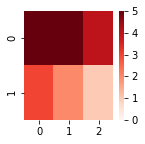

In [20]:
a=np.array([[1,2,3],[4,5,6]])[::-1].T[::-1].T
plt.figure(figsize=(2,2))
sns.heatmap(a, vmin=0,vmax=5,cmap='Reds')
plt.show()